<a href="https://colab.research.google.com/github/vrangayyan6/GenAI/blob/main/Cerebras_Multi_agent_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using AI to Streamline Research for Content Creation
## The Problem
Content creators, researchers, and marketers face a significant challenge when developing comprehensive material on specialized topics. The traditional research process is both time-consuming and labor-intensive:

They must formulate effective search queries
Sift through numerous search results manually
Evaluate the relevance and credibility of sources
Extract and organize key information
Synthesize findings into coherent content
Repeat this process multiple times to fill knowledge gaps

This workflow can take hours or even days, delaying content production and limiting the number of topics a team can cover effectively. For small teams or individual creators without research assistants, this bottleneck severely impacts productivity.

## The AI Solution
Generative AI, as demonstrated in the code you shared, can transform this process through automated research assistance:

- Query Optimization: The AI refines user queries to match search engine algorithms for better results (as shown in the format_search method)
- Automated Information Gathering: Instead of manual searching, the AI conducts multiple search queries and aggregates the results
- Intelligent Gap Analysis: The system evaluates the completeness of research and automatically identifies missing information (via the EditorAgent)
- Iterative Research: The AI conducts multiple rounds of research until sufficient information is gathered, targeting different aspects of the topic with each iteration
- Content Synthesis: When research is complete, the AI transforms raw research into well-structured content (via the WriterAgent)

## Real-World Impact
This AI-powered research workflow reduces what might take hours into minutes. Content creators can focus on refining and adding their unique perspective to AI-generated drafts rather than spending time on initial research and organization.
The solution is particularly valuable for:

- Marketing teams needing to create content across multiple product lines
- Researchers exploring new domains quickly
- Educational content creators covering diverse topics
- Small businesses without dedicated research staff

By increasing the number of search results (as you've requested), the system becomes even more effective, gathering a wider range of perspectives and information in each research iteration.

# Multi Agentic Workflow with Cerebras, Google, LangChain and LangGraph

Got early access to Meta’s latest model, Llama 4, running at 2611 tok/s, the fastest inference speed available at [cloud.cerebras.ai](https://cloud.cerebras.ai) and trying it out in this notebook.

https://inference-docs.cerebras.ai/introduction

# Cerebras API Key
Get Cerebras API key at https://cloud.cerebras.ai/

# LangChain key
Follow steps in
https://docs.smith.langchain.com/administration/how_to_guides/organization_management/create_account_api_key

# Setting up Google Search API Credentials

Before running the main code, you need to set up your Google Search API credentials:

## Step 1: Get a Google API Key
1. Go to the [Google Cloud Console](https://console.cloud.google.com/)
2. Create a new project or select an existing one
3. Enable the "Custom Search API" for your project
4. Go to "Credentials" and create an API key

## Step 2: Create a Programmable Search Engine
1. Go to [Programmable Search Engine](https://programmablesearchengine.google.com/about/)
2. Click "Create a Programmable Search Engine"
3. Configure your search engine (you can search the entire web)
4. After creation, find your "Search engine ID" (also called CSE ID)


In [1]:
!pip install -q langchain_cerebras langchain_community langgraph langchain langchain-core langsmith langchain_experimental cerebras_cloud_sdk langchain-google-community google-search-results requests beautifulsoup4


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 670.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.3/433.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
import os
import time
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import END
from langchain_cerebras import ChatCerebras

from google.colab import userdata
from IPython.display import Markdown
from typing import List, Dict, Tuple

## Configure API Keys
Add API keys in Secrets (left menu)

In [3]:
# Make sure these are set BEFORE creating any search wrappers
os.environ["GOOGLE_CSE_ID"] = userdata.get('GOOGLE_CSE_ID')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLESEARCH_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
api_key = userdata.get('CEREBRAS_API_KEY')

## Enable Tracing

LangChain offers an optional tracing feature that helps in debugging complex chains and workflows.

In [4]:
# Add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"

## Setup Data Storage

We initialize a simple in-memory list to store results from the agent workflow:

In [5]:
final_result = []

## Define Shared State

We use a TypedDict class to define and track the shared state between agents. This makes it easier to debug and enforce consistency.

In [6]:
class State(TypedDict):
    query: Annotated[list, add_messages]
    url: Annotated[list, add_messages]
    research: Annotated[list, add_messages]
    content: str
    content_ready: bool
    iteration_count: int     # Counter for iterations

## Initialize the Language Model

We use Google's Gemini model via LangChain’s wrapper.

In [7]:
# Initialize ChatCerebras instance for language model
llm = ChatCerebras(api_key=api_key, model="llama-4-scout-17b-16e-instruct")

## Research Agent

format_search(): Uses Gemini to transform natural queries into more search-optimized forms.

search(): Executes a search via GoogleSearchRun and stores results in state.

🔁 Iteration results are logged in final_result for each loop of query → search.

In [8]:
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_google_community import GoogleSearchRun
from langchain_core.messages import HumanMessage
import requests
from bs4 import BeautifulSoup

class ResearchAgent:
    def format_search(self, query: str) -> str:
        prompt = (
            "You are an expert at optimizing search queries for Google. "
            "Your task is to take a given query and return an optimized version of it, making it more likely to yield relevant results. "
            "Do not include any explanations or extra text, only the optimized query.\n\n"
            "Example:\n"
            "Original: best laptop 2023 for programming\n"
            "Optimized: top laptops 2023 for coding\n\n"
            "Example:\n"
            "Original: how to train a puppy not to bite\n"
            "Optimized: puppy training tips to prevent biting\n\n"
            "Now optimize the following query:\n"
            f"Original: {query}\n"
            "Optimized:"
        )

        response = llm.invoke(prompt)
        return response.content

    def fetch_full_content(self, url: str) -> str:
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'}
            response = requests.get(url, headers=headers, timeout=30)
            response.raise_for_status()  # Raise an exception for bad status codes
            soup = BeautifulSoup(response.content, 'html.parser')
            # Extract text content - you might need to adjust the selectors
            text_parts = soup.find_all('p')  # Example: get all paragraph text
            full_text = "\n".join([part.get_text() for part in text_parts])
            if full_text=="":
                full_text = soup.get_text()[:5000]
            return f"{full_text[:5000]} " # Limit content length
        except requests.exceptions.RequestException as e:
            return f"URL: {url}\nError fetching content: {e}"
        except Exception as e:
            return f"URL: {url}\nError parsing content: {e}"

    def search(self, state: State):    #  -> Dict[str, List[HumanMessage]]
        google_search = GoogleSearchAPIWrapper(k=10)
        optimized_query = self.format_search(state.get('query', "")[-1].content)
        raw_results = google_search.results(optimized_query, 1)

        if raw_results and raw_results[0].get('link'):
            url = raw_results[0]['link']
            full_content = self.fetch_full_content(url)
            time.sleep(1) # Be respectful of website rate limits
        else:
            full_content = "No content found"
            url = "No url found"

        final_result.append({"subheader": f"Research Iteration", "content": [full_content], "time": time.perf_counter() - time.perf_counter()}) # Correct the time calculation

        return {"research": full_content, "url": url, "query": optimized_query}


## Editor Agent
Uses Gemini to inspect accumulated research.

If results are sufficient, it sets content_ready = True.

If insufficient, it generates a new improved query and continues the loop.

🔐 Includes a hard limit of 10 iterations to prevent infinite loops.

In [9]:
class EditorAgent:
    def evaluate_research(self, state: State):
        query = '\n'.join(message.content for message in state.get("query"))
        research_content = "\n".join([message.content for message in state.get("research")])

        iteration_count = state.get("iteration_count", 1)

        if iteration_count is None:
            iteration_count = 1

        if iteration_count >= 3:
            return {"content_ready": True}

        prompt = (
            "You are an expert editor. Your task is to evaluate the research based on the query. "
            "If the information is sufficient to create a comprehensive and accurate blog post, respond with 'sufficient'. "
            "If the information is not sufficient, respond with 'insufficient' and provide a new, creative query suggestion to improve the results. "
            "If the research results appear repetitive or not diverse enough, think about a very different kind of question that could yield more varied and relevant information. "
            "Consider the depth, relevance, and completeness of the information when making your decision.\n\n"
            "Example 1:\n"
            "Used queries: What are the benefits of a Mediterranean diet?\n"
            "Research: The Mediterranean diet includes fruits, vegetables, whole grains, and healthy fats.\n"
            "Evaluation: Insufficient\n"
            "New query: Detailed health benefits of a Mediterranean diet\n\n"
            "Example 2:\n"
            "Used queries: How does solar power work?\n"
            "Research: Solar power works by converting sunlight into electricity using photovoltaic cells.\n"
            "Evaluation: Sufficient\n\n"
            "Example 3:\n"
            "Used queries: Effects of climate change on polar bears?\n"
            "Research: Climate change is reducing sea ice, affecting polar bear habitats.\n"
            "Evaluation: Insufficient\n"
            "New query: How are polar bears adapting to the loss of sea ice due to climate change?\n\n"
            "Now evaluate the following:\n"
            f"Used queries: {query}\n"
            f"Research: {research_content}\n\n"
            "Evaluation (sufficient/insufficient):\n"
            "New query (if insufficient):"
        )

        start_time = time.perf_counter()
        response = llm.invoke(prompt)
        end_time = time.perf_counter()

        evaluation = response.content.strip()

        final_result.append({"subheader": f"Editor Evaluation Iteration", "content": evaluation, "time": end_time - start_time})

        if "new query:" in evaluation.lower():
            new_query = evaluation.split("New query:", 1)[-1].strip()
            return {"query": [new_query], "iteration_count": iteration_count + 1, "evaluation": evaluation}
        else:
            return {"content_ready": True, "evaluation": evaluation}


## Writer Agent
Combines query and research into a single blog post.

Uses Gemini to generate detailed, structured content (intro, body, conclusion).

In [10]:
class WriterAgent:
    def write_blogpost(self, state: Dict) -> Dict[str, str]:
        # Handle query access more safely
        query = state.get("query", [""])[0].content if isinstance(state.get("query", [""]), list) else state.get("query", "")
        context = "\n".join([f"[{i+1}] {message.content} \n" for i, message in enumerate(state.get("research", []))])
        references = "\n".join([f"[{i+1}] {message.content} \n" for i, message in enumerate(state.get("url", []))])

        prompt = (
            "You are an expert blog post writer. Your task is to take a given query and context, and write a comprehensive, engaging, and informative short blog post about it. "
            "Make sure to include an introduction, main body with detailed information, and a conclusion. Use a friendly and accessible tone, and ensure the content is well-structured and easy to read. "
            "Cite the sources you used by referring to the number in the square brackets with References section at the bottom of the blog post."
            "Do not add anything other content not in the sources.\n\n"
            f"Query: {query}\n\n"
            f"Context:\n{context}\n\n"
            f"**References:**\n{references}"
            "Write a detailed and engaging blog post based on the above query and context."
        )

        response = llm.invoke(prompt)

        return {"content": response.content}

## Define the LangGraph
🔄 This creates a loop between search_agent → editor_agent → (search or writer).

In [11]:
# Initialize the StateGraph
graph = StateGraph(State)

research_agent = ResearchAgent()
writer_agent = WriterAgent()
editor_agent = EditorAgent()

graph.add_node("search_agent", research_agent.search)
graph.add_node("writer_agent", writer_agent.write_blogpost)
graph.add_node("editor_agent", editor_agent.evaluate_research)

graph.set_entry_point("search_agent")

graph.add_edge("search_agent", "editor_agent")

graph.add_conditional_edges(
    "editor_agent",
    lambda state: "accept" if state.get("content_ready") else "revise",
    {
        "accept": "writer_agent",
        "revise": "search_agent"
    }
)

graph.add_edge("writer_agent", END)

graph = graph.compile()

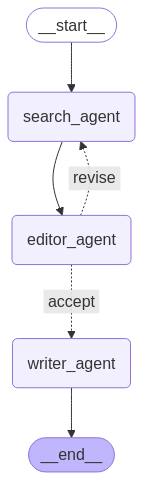

In [12]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

## Main Invocation Function
This function:

Starts the LangGraph with the user’s query

Automatically loops through agents until content_ready

Returns the final blog post

In [13]:
def invoke_graph(user_prompt):
    start_time = time.perf_counter()
    result = graph.invoke({"query": user_prompt})
    end_time = time.perf_counter()
    print("\n\n")
    print(f"Total time: {end_time - start_time} seconds")
    print("\n\n")
    return result["content"]

# Provide your prompt below

In [14]:
user_prompt = "Act as an expert in Financial Services, explain in detail on separately managed accounts using 5000 words or more."

# View response
You will see the Google search results in the first section, and the blogpost generated in the next.

In [15]:
Markdown(invoke_graph(user_prompt))




Total time: 6.831050043000005 seconds





**The Power of Separately Managed Accounts: Unlocking Personalized Investment Experiences and Tax Efficiency**

In the world of financial services, investors are constantly seeking ways to optimize their investment portfolios, minimize taxes, and achieve their financial goals. One strategy that has gained popularity in recent years is separately managed accounts (SMAs). In this blog post, we will delve into the world of SMAs, exploring how they work, their benefits, and the innovative approaches offered by PGIM Custom Harvest.

**What is a Separately Managed Account (SMA)?**

A separately managed account is a type of investment account that allows individuals to own a portfolio of securities, such as stocks, bonds, or exchange-traded funds (ETFs), that are managed by a professional investment manager [1]. Unlike mutual funds or ETFs, SMAs offer a high degree of customization, allowing investors to tailor their portfolios to meet their specific investment objectives, risk tolerance, and tax situation.

**How Does an SMA Work?**

When an investor opens an SMA, they typically work with an investment manager to create a customized portfolio that aligns with their investment goals and risk profile. The investment manager then actively manages the portfolio, buying and selling securities as needed to achieve the investor's objectives [1]. SMAs can be structured to provide exposure to a specific asset class, sector, or geographic region, and can also incorporate tax management strategies to help minimize tax liabilities.

**The Benefits of Separately Managed Accounts**

SMAs offer several benefits to investors, including:

1. **Personalized investment experience**: SMAs allow investors to create a customized portfolio that aligns with their individual investment goals, risk tolerance, and tax situation.
2. **Tax efficiency**: SMAs can be structured to incorporate tax management strategies, such as tax-loss harvesting, to help minimize tax liabilities.
3. **Flexibility**: SMAs offer investors the flexibility to make changes to their portfolio as needed, allowing them to respond to changes in their financial situation or investment objectives.
4. **Transparency**: SMAs provide investors with complete transparency into their portfolio holdings and investment strategy.

**PGIM Custom Harvest: A Leader in Direct Indexing using ETFs**

PGIM Custom Harvest is a leader in the development of tax-beneficial investment strategies using ETFs for clients seeking improved after-tax outcomes [2]. Their SMA platform offers a range of strategies designed to provide exposure to client-selected benchmarks while generating tax alpha. By using ETFs, PGIM Custom Harvest's SMAs offer a number of benefits, including:

1. **Full market participation**: PGIM Custom Harvest's SMAs provide full market participation through portfolios of ETFs, offering enhanced opportunities for tax loss capture in down markets and appreciation in up markets.
2. **Active tax management**: PGIM Custom Harvest's active tax management discipline aims to deliver tax efficiency through a loss capture process that is designed to help offset both capital gains within the portfolios and realized gains outside of the portfolios.
3. **Customization**: PGIM Custom Harvest's SMAs can be customized to meet individual client needs, providing a personalized investment experience.

**The PGIM Custom Harvest SMA Platform**

The PGIM Custom Harvest SMA platform offers a range of strategies designed to provide investors with broad exposure to the equity and fixed income markets while minimizing taxes. Their strategies include:

1. **U.S. Equity Strategy**: Seeks to provide broad global equity market exposure while capturing tax benefits.
2. **Hedged Equity Strategy**: Seeks to provide 50% hedged exposure to the broad domestic equity market through long and short portfolio positions while capturing tax benefits.
3. **International Equity Strategy**: Seeks to provide broad international market exposure while capturing tax benefits.

**Meet the Team: Robert Holderith and Brian Ahrens**

PGIM Custom Harvest is led by Robert Holderith, who joined PGIM Investments in December 2021 and founded Green Harvest Asset Management in 2017 [2]. Robert has been implementing, structuring, and developing ETFs and related strategies since 1999. Brian Ahrens, CIO at PGIM Custom Harvest, has over 30 years of experience with Prudential and is responsible for investment consulting, portfolio construction, and risk oversight activities.

**Conclusion**

Separately managed accounts offer investors a powerful tool for achieving their investment goals while minimizing taxes. PGIM Custom Harvest's SMA platform provides a range of strategies designed to provide exposure to client-selected benchmarks while generating tax alpha. By using ETFs and incorporating active tax management, PGIM Custom Harvest's SMAs offer a number of benefits, including full market participation, customization, and tax efficiency. Whether you're an individual investor or a financial advisor, SMAs are worth considering as a way to unlock personalized investment experiences and tax efficiency.

**References:**

[1] https://smartasset.com/investing/separately-managed-account 
[2] https://www.pgim.com/investments/pgim-custom-harvest-sma-platform